In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from xml.etree import ElementTree as et
import cv2
from skimage.io import imread, imshow
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from engine import train_one_epoch, evaluate
import warnings
warnings.filterwarnings('ignore')

In [3]:
root = '../input/fruit-images-for-object-detection'
import torch
torch.cuda.empty_cache()

In [4]:
class Fruit_dataset(Dataset):
    def __init__(self,root,dataset,transforms=None):
        super().__init__()
        self.root = root
        self.transforms = transforms
        self.dataset = dataset
        self.images = [img for img in os.listdir(os.path.join(self.root,f'{dataset}_zip',dataset)) if img[-1]=='g' ]
        #print(len(self.images),os.listdir(os.path.join(self.root,f'{dataset}_zip',dataset)))
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        img_path = os.path.join(os.path.join(self.root,f'{self.dataset}_zip',self.dataset),self.images[idx])
        #print(img_path)
        #img = cv2.imread(img_path)
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)
        #print(img.shape)
        h,w = img.shape[0],img.shape[1]
        img = cv2.resize(img,(480,480)).astype(np.float32)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).
        #img = cv.normalize(img,  None, 0, 255, cv.NORM_MINMAX,dtype=cv2.CV_32F)
        img /= 255.0
        xml_path = os.path.join(os.path.join(self.root,f'{self.dataset}_zip',self.dataset),self.images[idx].replace('jpg','xml'))
        
        labels = []
        bb_cord = []
        
        tree = et.parse(xml_path)
        root = tree.getroot()
        
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)/w*480
            xmax = float(bbox.find('xmax').text)/w*480
            ymin = float(bbox.find('ymin').text)/h*480
            ymax = float(bbox.find('ymax').text)/h*480
            labels.append(obj.find('name').text)
            bb_cord.append([xmin,ymin,xmax,ymax])
        
        classes = [_,'apple','banana','orange']
        labels = torch.as_tensor([classes.index(label) for label in labels],dtype = torch.int64)
        bb_cord = torch.as_tensor(bb_cord,dtype = torch.float32)
        iscrowd = torch.zeros((bb_cord.shape[0]), dtype=torch.int32)
        area = (bb_cord[:,2]-bb_cord[:,0])*(bb_cord[:,3]-bb_cord[:,1])

        target = {'labels' : labels,
          'boxes' : bb_cord,
          'area' : area,
          'iscrowd' : iscrowd,
          'image_id' : torch.tensor([idx])
          }
        #plt.imshow(img)
        sample = {
        'image': img,
        'bboxes': target['boxes'],
        'labels': labels
        }
        sample = self.transforms(**sample)
        img = sample['image']
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            
        return img,target
    
    
def get_transforms(train):
    if train:
        return A.Compose([A.Flip(0.5),ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
train_dataset = Fruit_dataset(root,'train',get_transforms(train=True))
test_dataset = Fruit_dataset(root,'test',get_transforms(train=False))
train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=2, shuffle=True,collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=True,collate_fn=collate_fn)

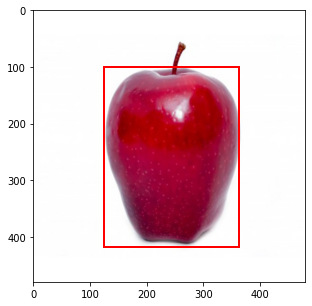

In [6]:
def plot_img_bbox(img, target):
    transform = torchvision.transforms. ToPILImage()
    img = transform(img)
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    #img = img.reshape(img.shape[1],img.shape[2],-1)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        a.add_patch(rect)
    plt.show()
img, target = test_dataset[4]
#img = img.reshape(img.shape[1],img.shape[2],-1)
#plt.imshow(img)
plot_img_bbox(img, target)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 10

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [9]:
itr = 1
for epoch in range(num_epochs):    
    for images, targets in train_dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")
        itr += 1

Iteration #50 loss: 0.23952108011618403
Iteration #100 loss: 0.1716970416644862
Iteration #150 loss: 0.11444878504660319


In [10]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

def torch_to_numpy(img):
    return img.detach().cpu().numpy()

60


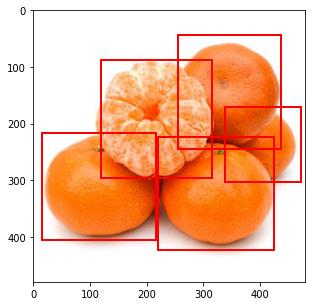

In [11]:
img, target = test_dataset[48]
print(len(test_dataset))
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    prediction = apply_nms(prediction)
    

plot_img_bbox(img, prediction)